In [1]:
import pandas as pd
import numpy as np
import yaml
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from C_model_opti import model_optimization, plot_estimation

##### 1. Load all data that is needed

In [2]:
# Load experimental data
df_exp = pd.read_csv('data/data_combined.csv')
biomass_exp = df_exp['Biomass [g/L]']
substrate_exp = df_exp['Glucose [g/L]']

In [3]:
# Load parameters from YAML file
with open('config/parameters.yml', 'r') as file:
    param = yaml.safe_load(file)

mu_max = param['mu_max']
X_max = param['X_max']
Ks = param['Ks']
Ks_qs = param['Ks_qs']
Ki = param['Ki']
Yxs = param['Yxs']
qs_max = param['qs_max']
m_s = param['m_s']
lag = param['lag']

##### 2. Define all possible equations for mu and qs

In [4]:
# -- MONOD / insert: mu_max, c_glucose, Ks
mu0 = lambda mu_max, c_glucose, Ks: mu_max * c_glucose / (c_glucose + Ks)
# -- LOGISTIC / insert: mu_max, c_biomass, X_max
mu1 = lambda mu_max, c_biomass, X_max: mu_max * (1 - (c_biomass/ X_max)) 
# -- MONOD + LOGISTIC / insert: mu_max, c_glucose, Ks, c_biomass, X_max
mu2 = lambda mu_max, c_glucose, Ks, c_biomass, X_max: mu_max * (c_glucose / (c_glucose + Ks)) * (1 - (c_biomass/ X_max))
# -- MONOD + LOGISTIC + INHIBITION / insert: mu_max, c_glucose, Ks, Ki, c_biomass, X_max
mu3 = lambda mu_max, c_glucose, Ks, Ki, c_biomass, X_max: mu_max * (c_glucose / (c_glucose + Ks + (c_glucose**2/ Ki))) * (1 - (c_biomass/ X_max))

In [5]:
# -- MONOD / insert: qs_max, c_glucose, Ks_qs
qs0 = lambda qs_max, c_glucose, Ks_qs: qs_max * c_glucose / (Ks_qs + c_glucose)
# -- MONOD + NON COMPETITIVE INHIBITION / insert: qs_max, c_glucose, Ks_qs, Ki, glu_met
qs1 = lambda qs_max, c_glucose, Ks_qs, Ki, glu_met: qs_max * c_glucose / (Ks_qs + c_glucose) * (Ki / (Ki + glu_met))
# -- YIELD / insert: Yxs, f_glucose, V
qs2 = lambda Yxs, f_glucose, V: 1/Yxs * f_glucose / V #NOT SURE IF CORRECT because g_S/g_X but not per h
# -- MONOD + METABOLIZED GLU / insert: qs_max, c_glucose, Ks_qs, glu_met, lag
qs3 = lambda qs_max, c_glucose, Ks_qs, glu_met, lag: qs_max * c_glucose / (Ks_qs + c_glucose) * (1 / (np.exp(glu_met * lag)))

In [6]:
mu_all=[mu0, mu1, mu2, mu3]
qs_all=[qs0, qs1, qs2, qs3]

##### 3. Define functions that are needed

In [7]:
# Root mean squared error is the objective function
def objective_function(parameters, mu_eq, num_mu, qs_eq, num_qs):
    # Solve the model using the optimal parameters
    time_pred, biomass_pred, substrate_pred, volume_pred = model_optimization(param, parameters, mu_eq, num_mu, qs_eq, num_qs)  # Solve the model using the current parameters
    biomass = pd.concat([biomass_exp, pd.Series(biomass_pred)], axis=1, keys=['biomass_exp', 'biomass_pred']).dropna()
    biomass_exp_ = biomass['biomass_exp'].values
    biomass_pred_ = biomass['biomass_pred'].values
    mse_x = mean_squared_error(biomass_exp_, biomass_pred_)  # Calculate mean squared error for biomass

    glucose = pd.concat([substrate_exp, pd.Series(substrate_pred)], axis=1, keys=['substrate_exp', 'substrate_pred']).dropna()
    substrate_exp_ = glucose['substrate_exp'].values
    substrate_pred_ = glucose['substrate_pred'].values
    mse_s = mean_squared_error(substrate_exp_, substrate_pred_)  # Calculate mean squared error for substrate
    
    # Calculate the combined rmse
    mse = (mse_x + mse_s)/2
    rmse = np.sqrt(mse)  # Calculate root mean squared error
    return rmse, time_pred, biomass_pred, substrate_pred, volume_pred

##### 4. Define set of parameters in config file

In [8]:
# Extract the parameter combination and the number of the set in order to save it in the correct folder
est_mu_max = param['est_mu_max'] # ['set0']
est_Ks = param['est_ks']

##### 5. Run it

c:\Users\dxp2904\Downloads\Project_June_Ferm\hybrid-model-corynebacterium\C_model_opti.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


set mu qs  mu_max  X_max    Ks  Ks_qs    Ki   Yxs  qs_max  m_s     lag  \
52   3  1  0   0.225  23.16  10.0  0.035  7.15  0.48    0.57  0.1  0.0057   
36   2  1  0   0.225  23.16   7.0  0.035  7.15  0.48    0.57  0.1  0.0057   
4    0  1  0   0.225  23.16   1.0  0.035  7.15  0.48    0.57  0.1  0.0057   
20   1  1  0   0.225  23.16   5.0  0.035  7.15  0.48    0.57  0.1  0.0057   
68   4  1  0   0.225  23.16  20.0  0.035  7.15  0.48    0.57  0.1  0.0057   
55   3  1  3   0.225  23.16  10.0  0.035  7.15  0.48    0.57  0.1  0.0057   
23   1  1  3   0.225  23.16   5.0  0.035  7.15  0.48    0.57  0.1  0.0057   
71   4  1  3   0.225  23.16  20.0  0.035  7.15  0.48    0.57  0.1  0.0057   
39   2  1  3   0.225  23.16   7.0  0.035  7.15  0.48    0.57  0.1  0.0057   
7    0  1  3   0.225  23.16   1.0  0.035  7.15  0.48    0.57  0.1  0.0057   

     rmse  
52  5.388  
36  5.388  
4   5.388  
20  5.388  
68  5.388  
55  6.874  
23  6.874  
71  6.874  
39  6.874  
7   6.874

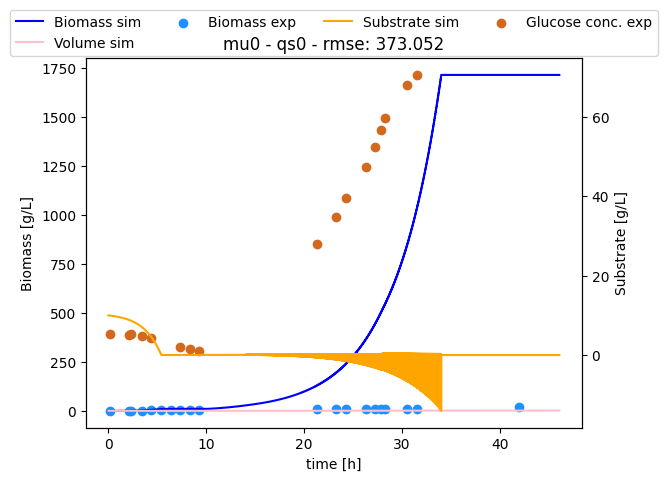

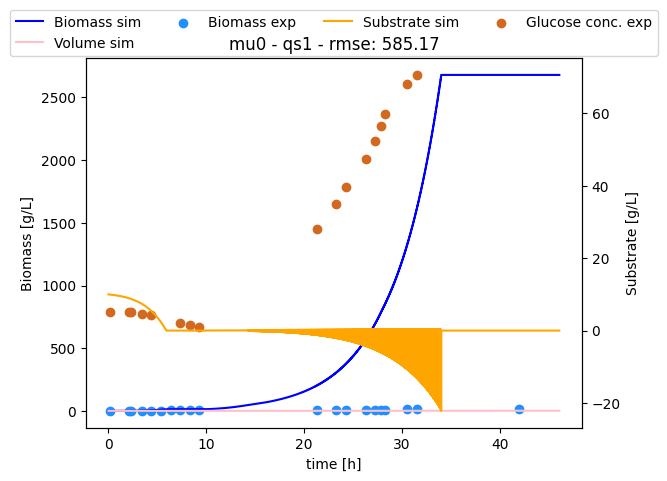

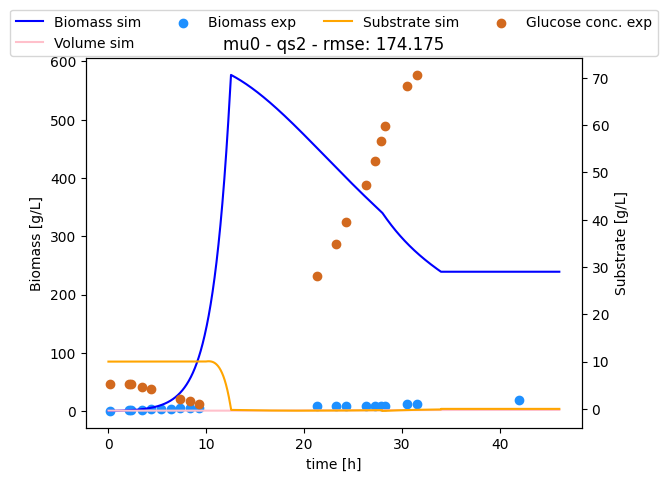

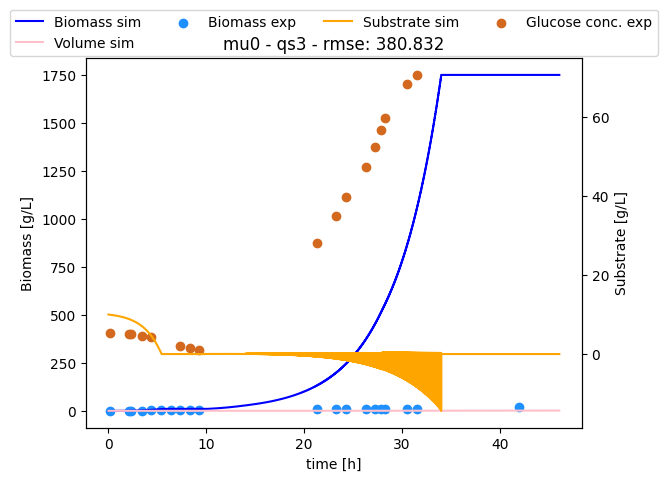

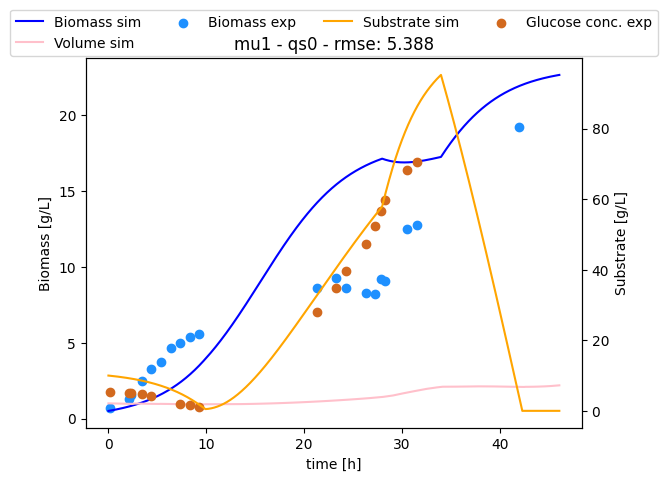

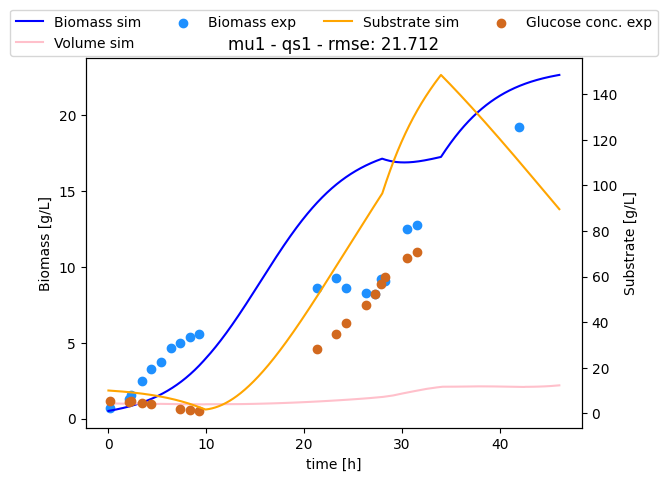

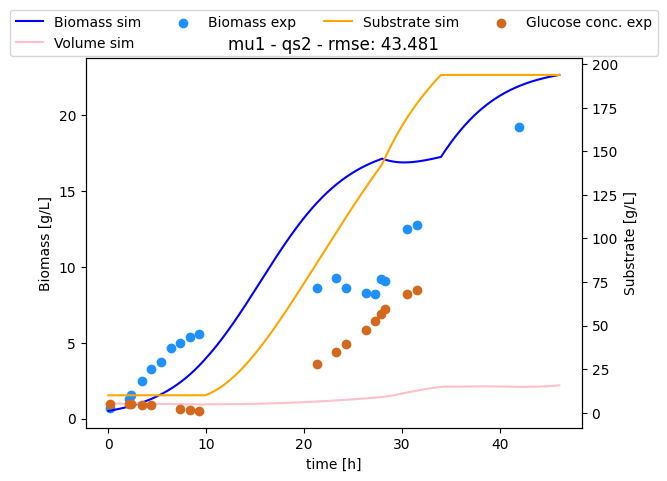

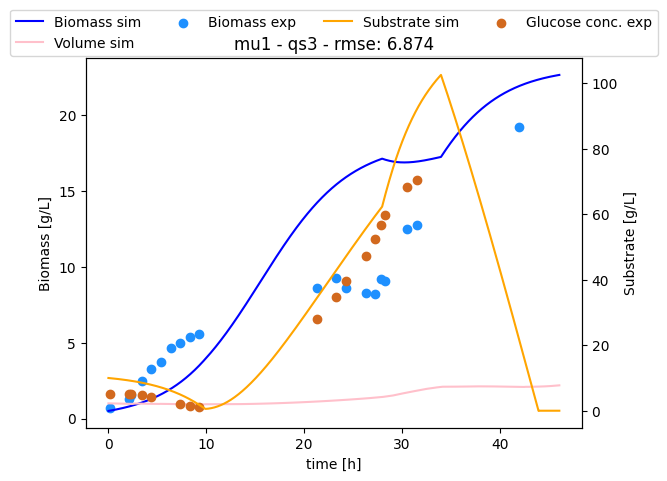

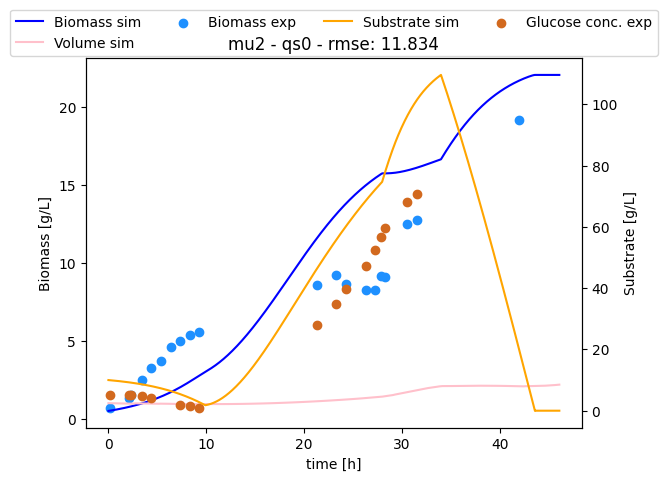

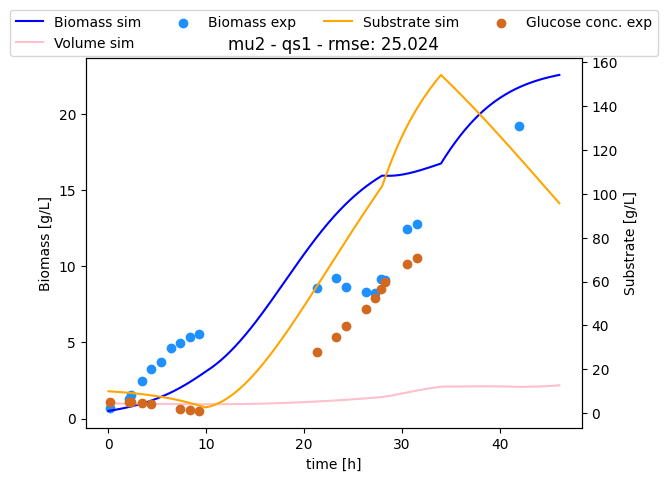

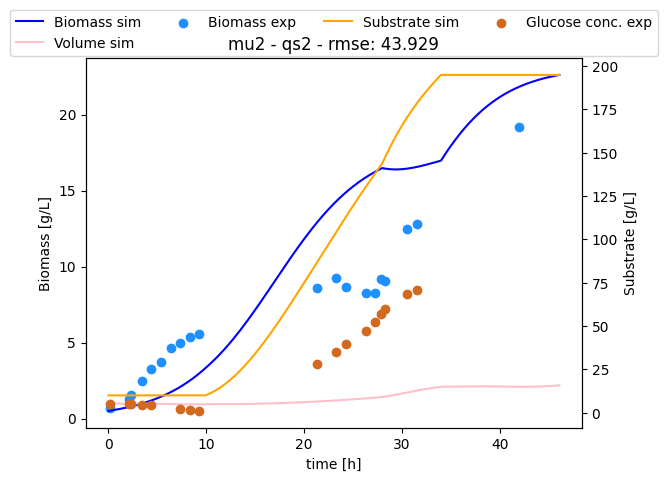

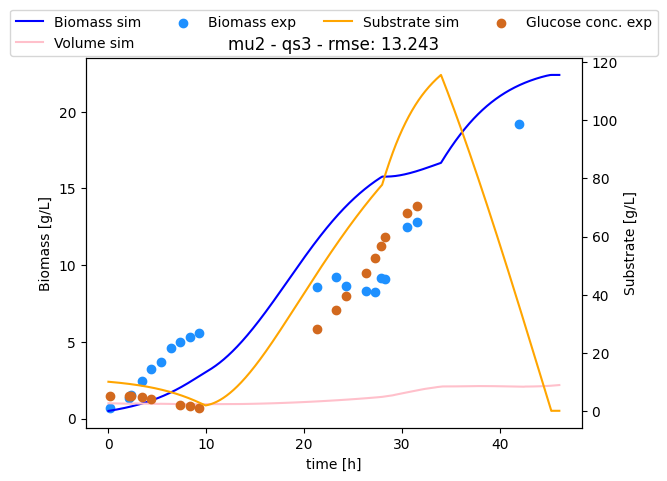

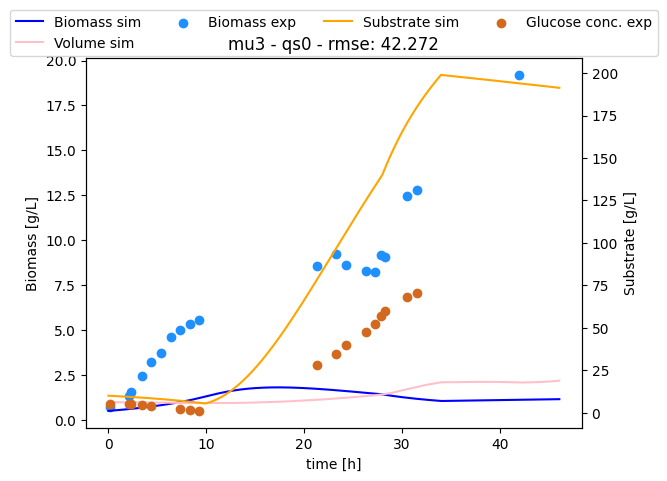

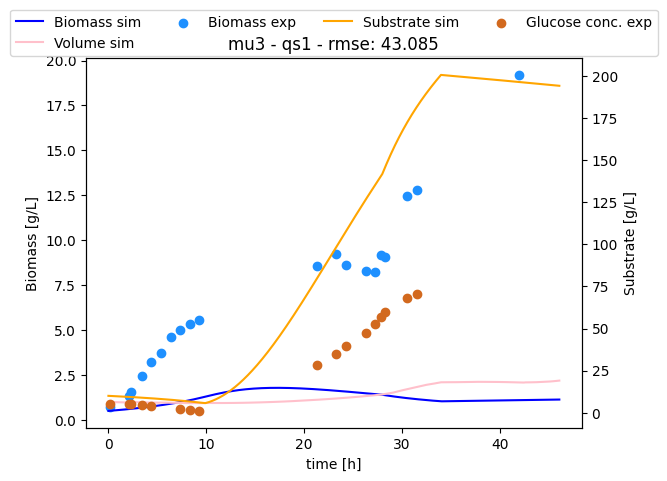

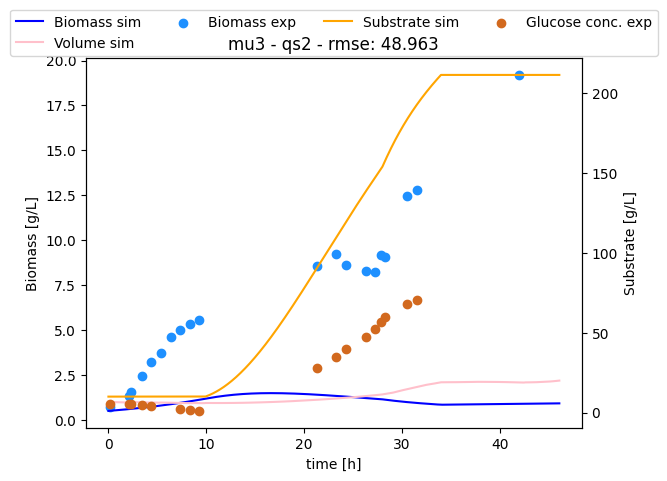

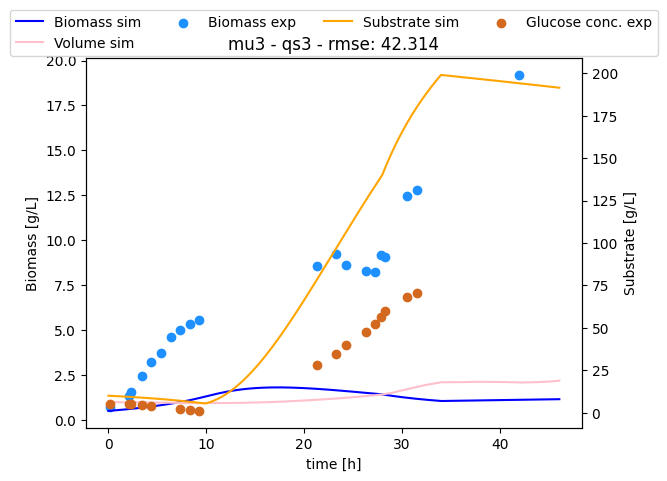

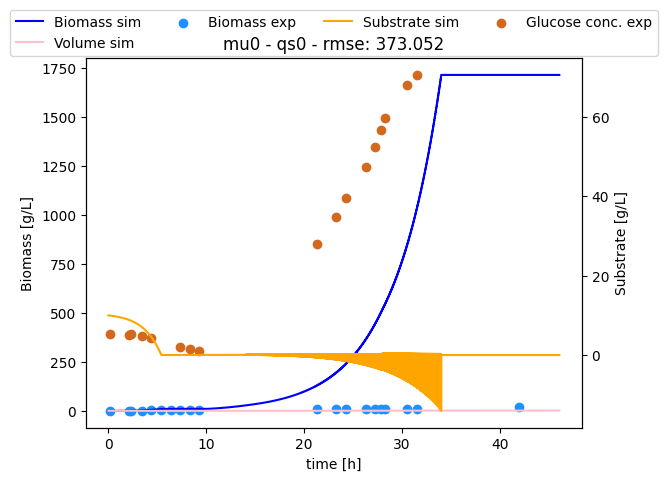

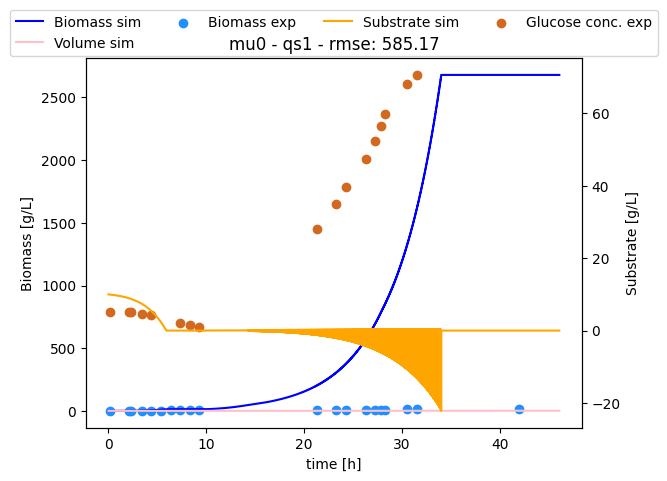

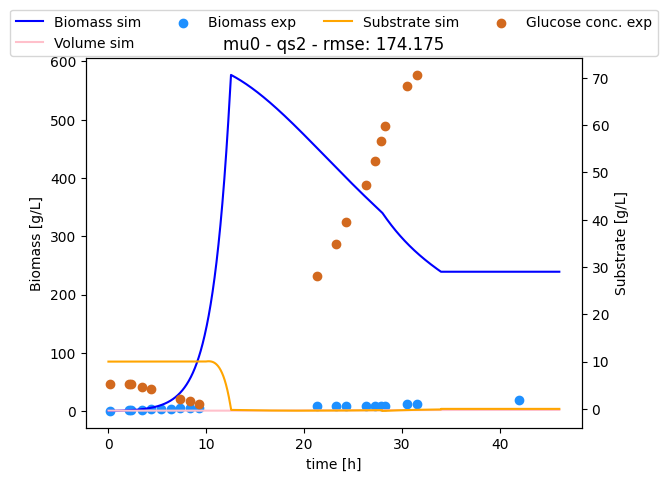

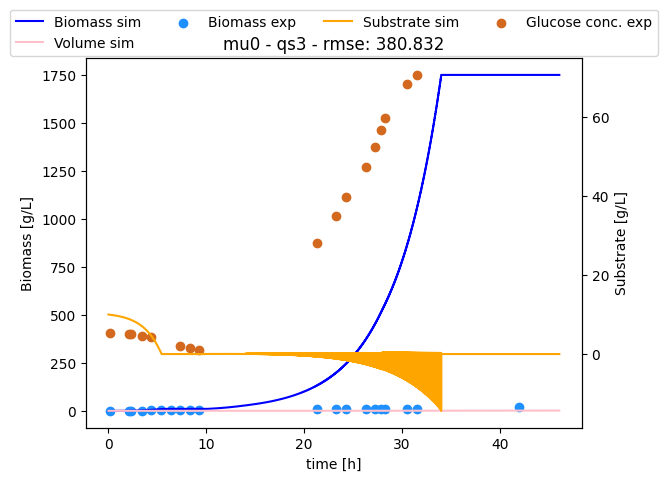

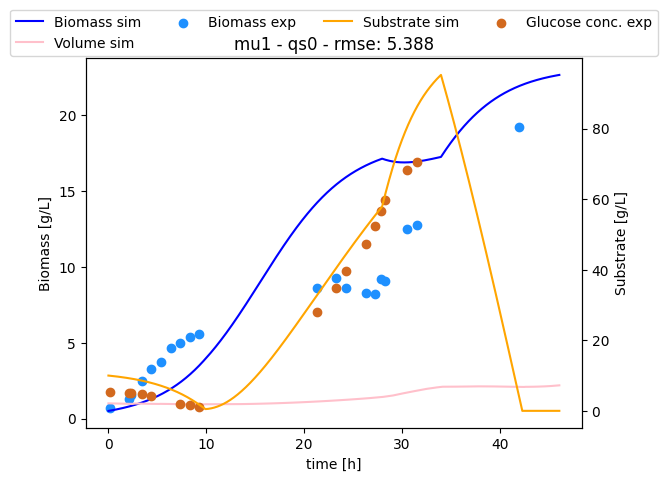

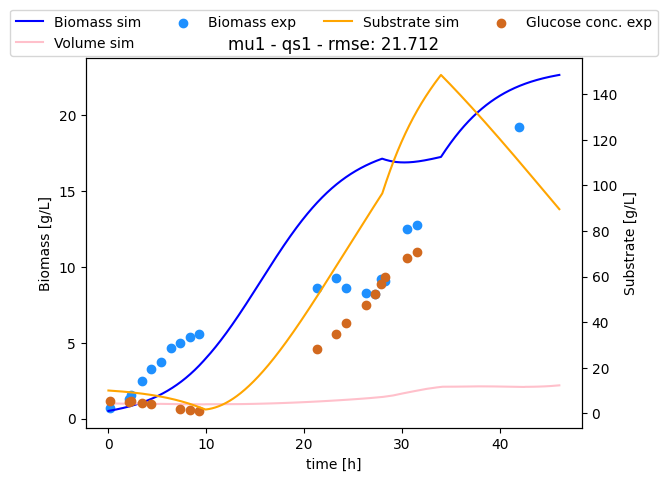

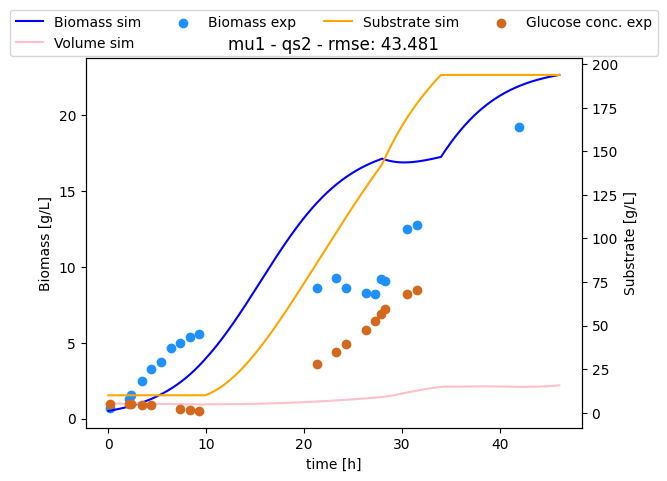

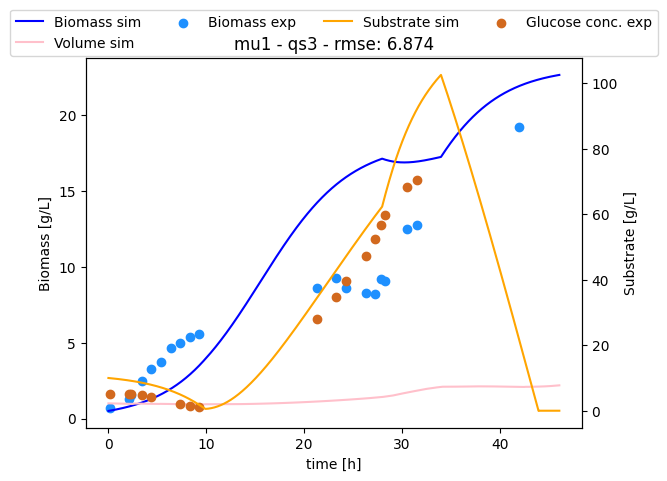

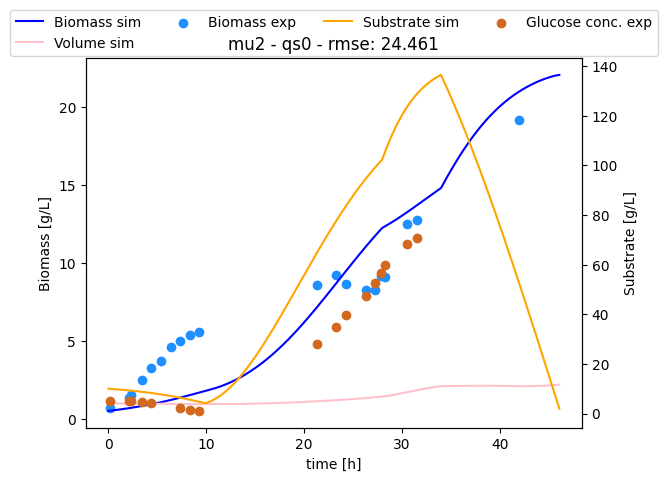

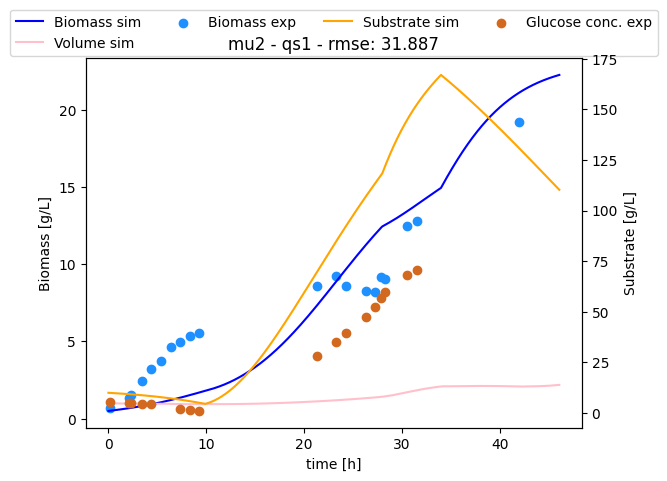

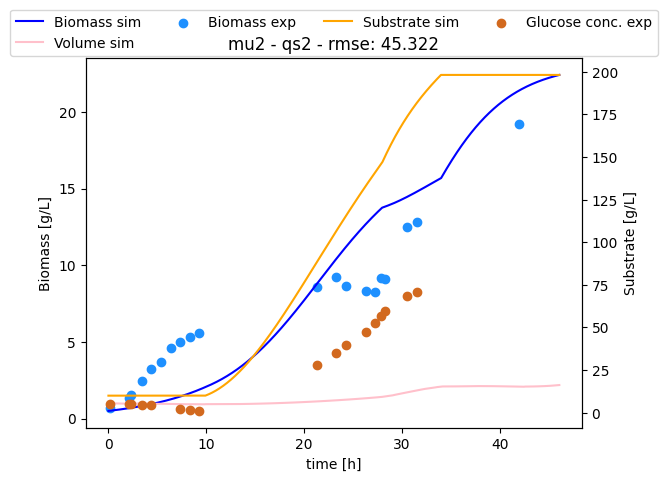

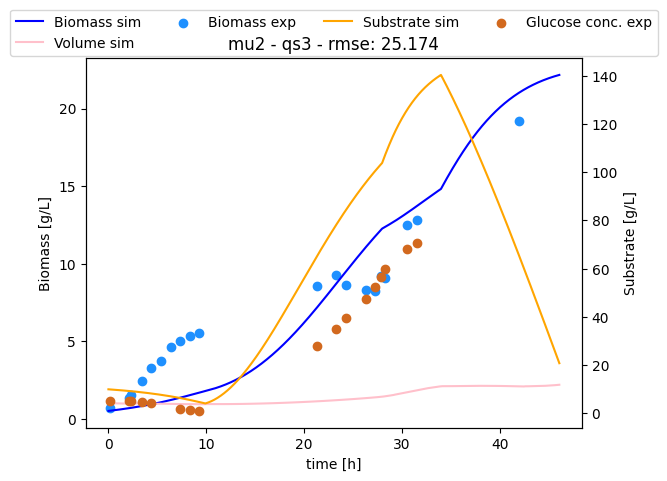

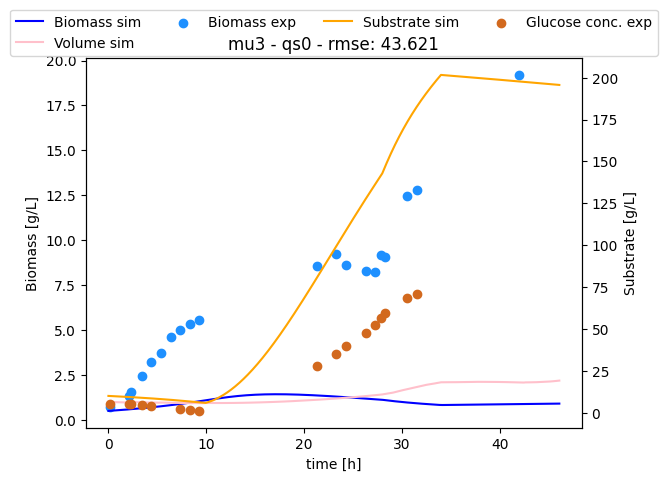

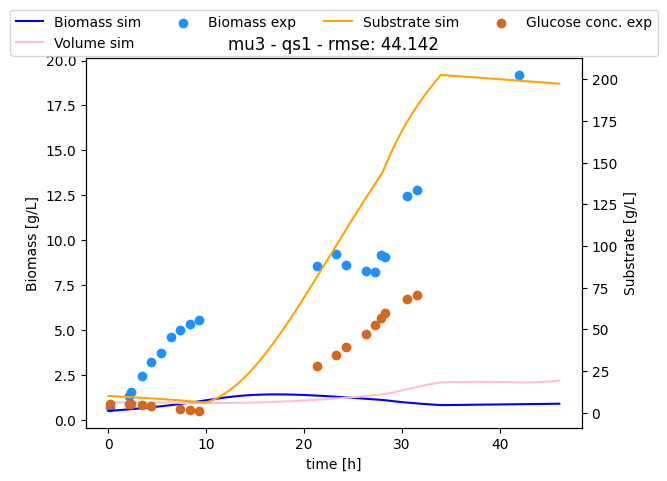

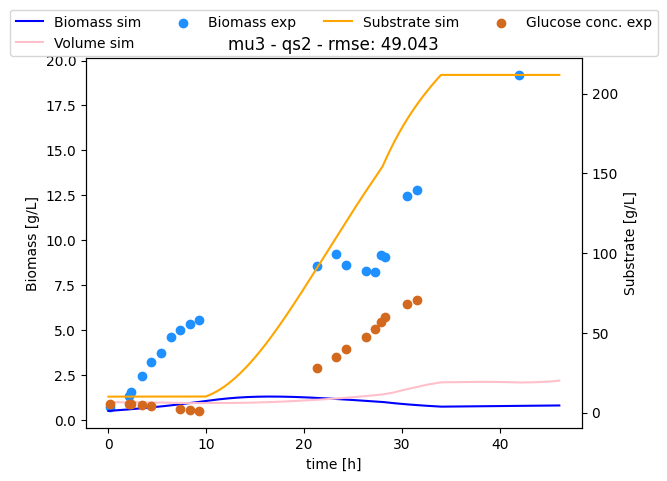

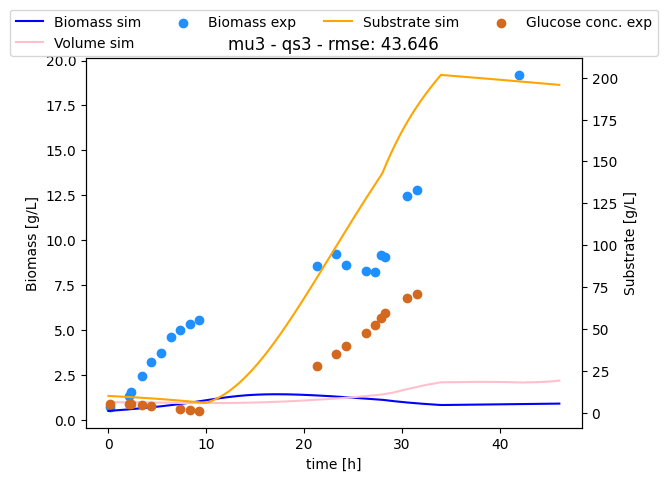

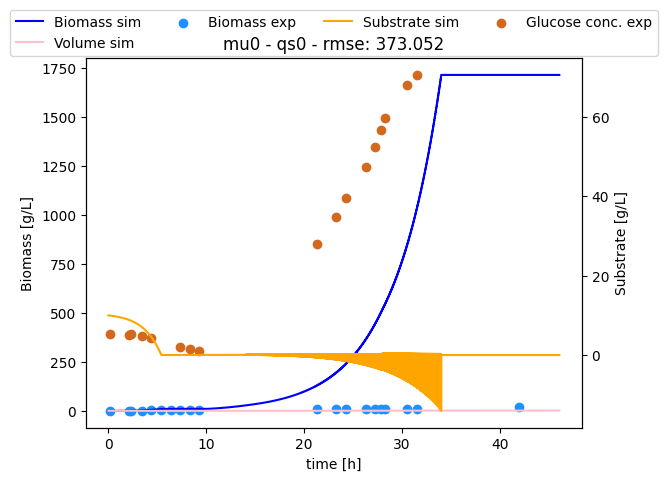

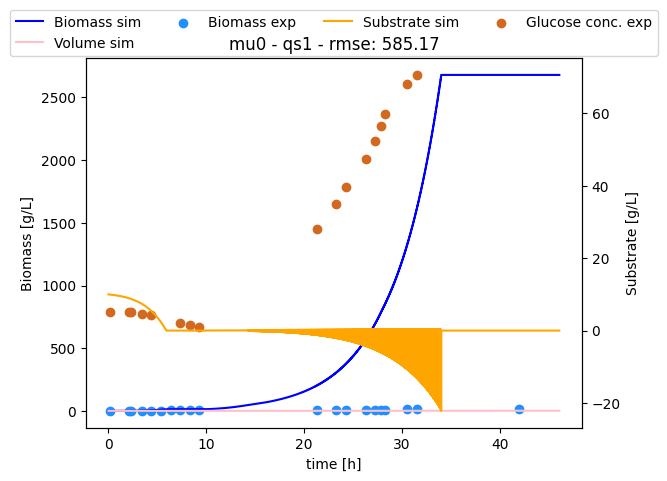

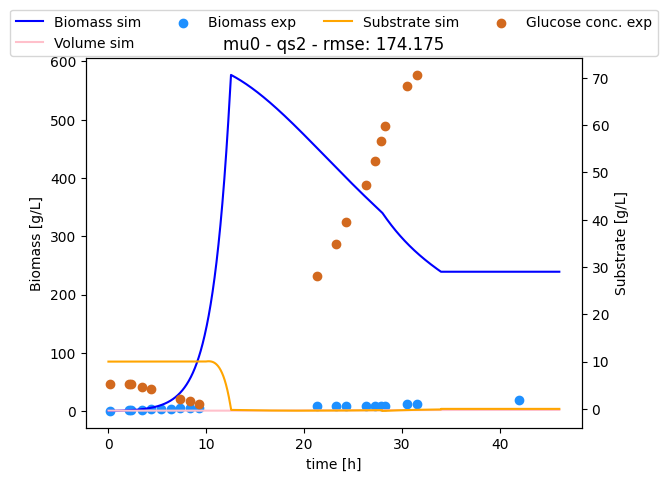

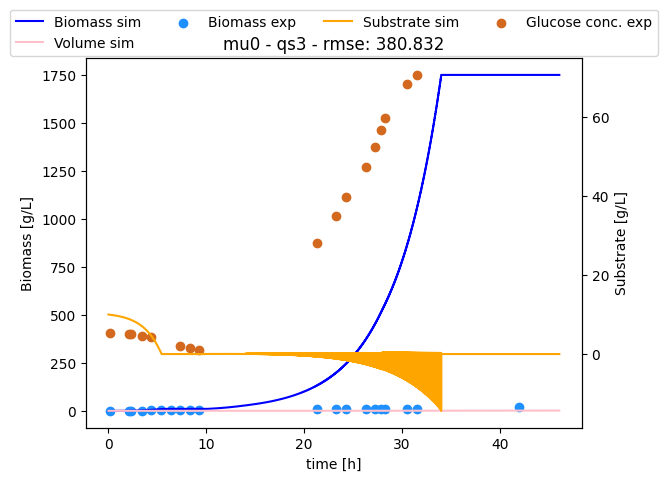

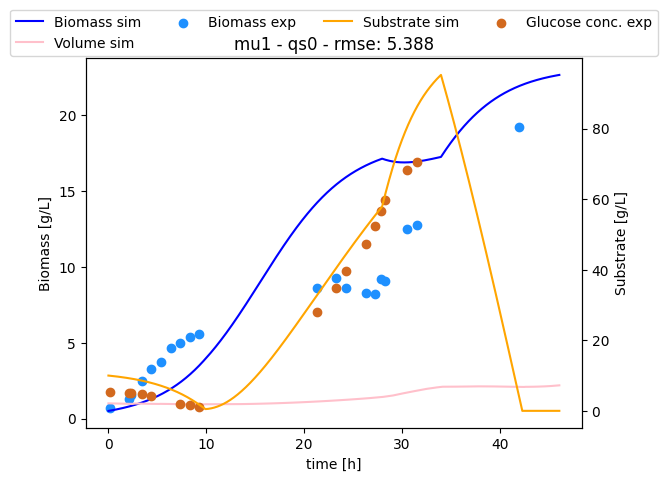

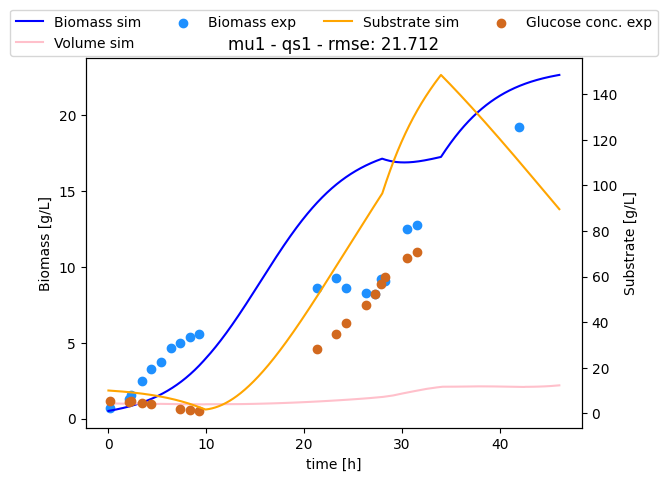

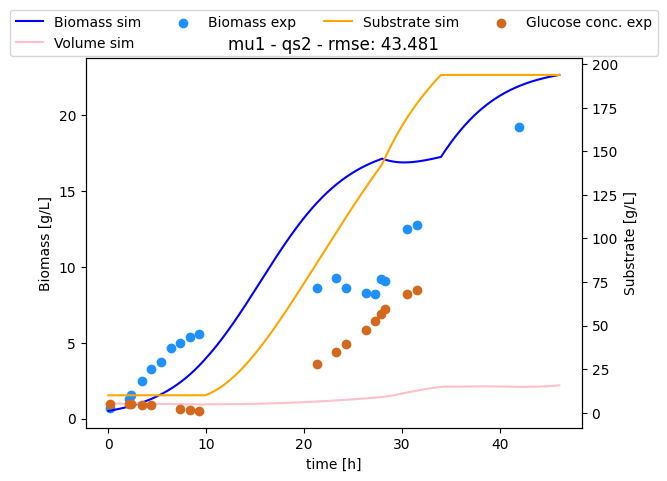

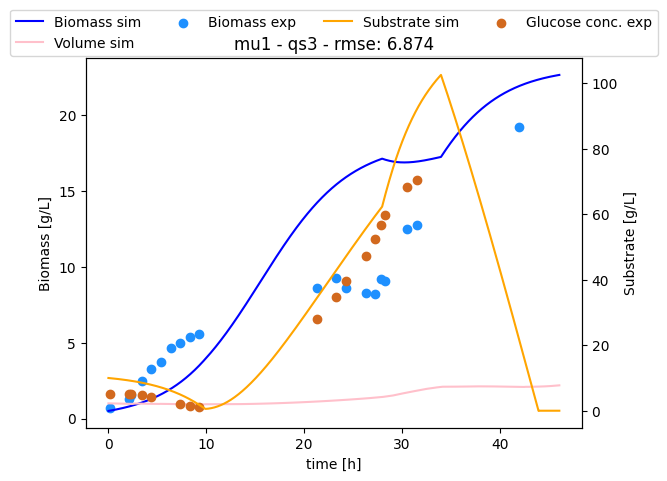

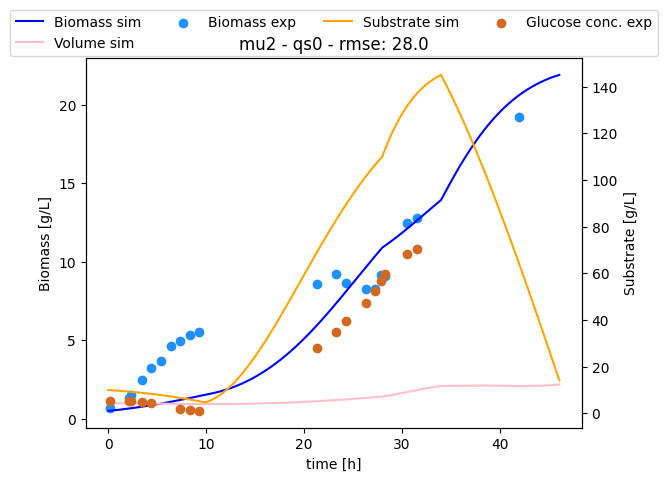

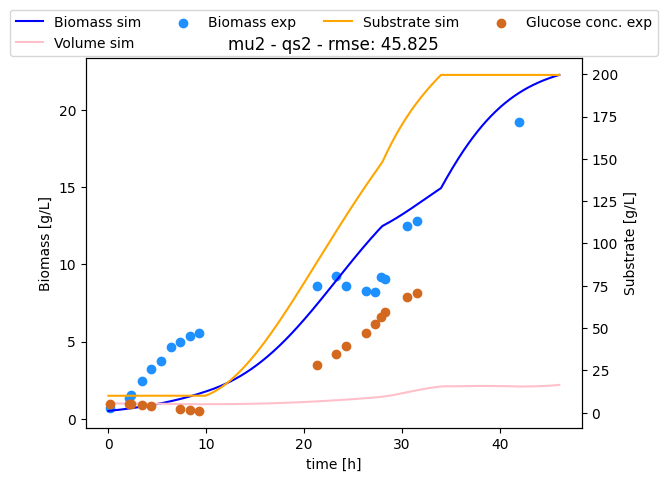

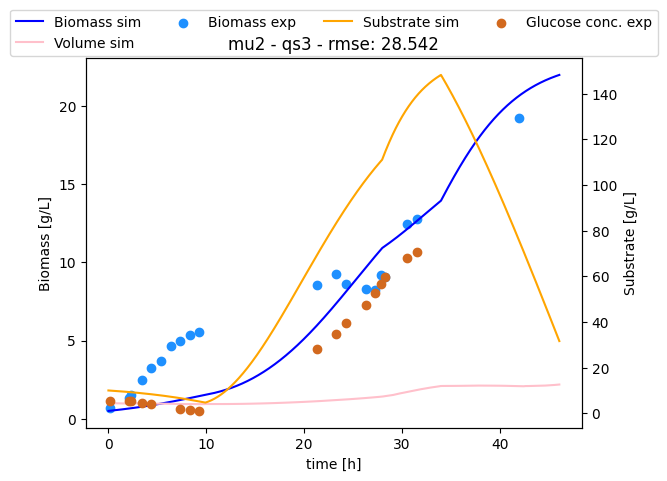

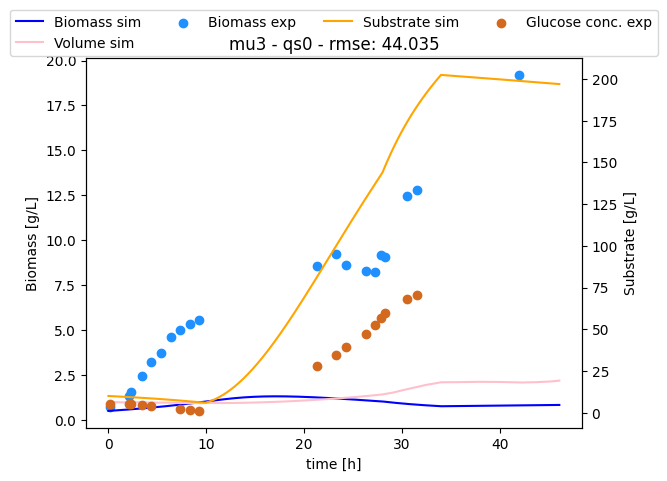

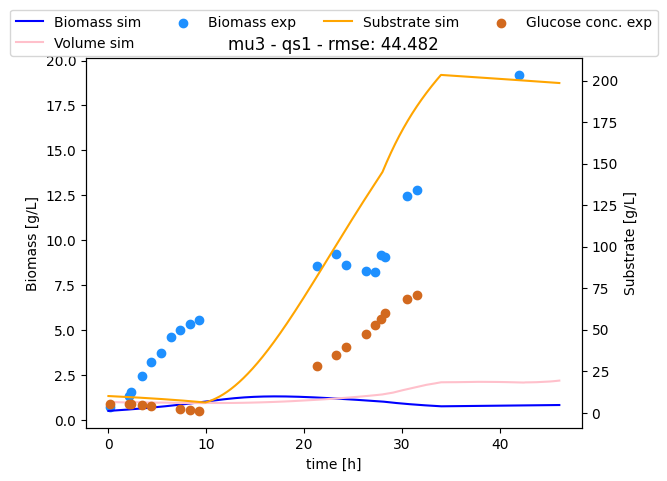

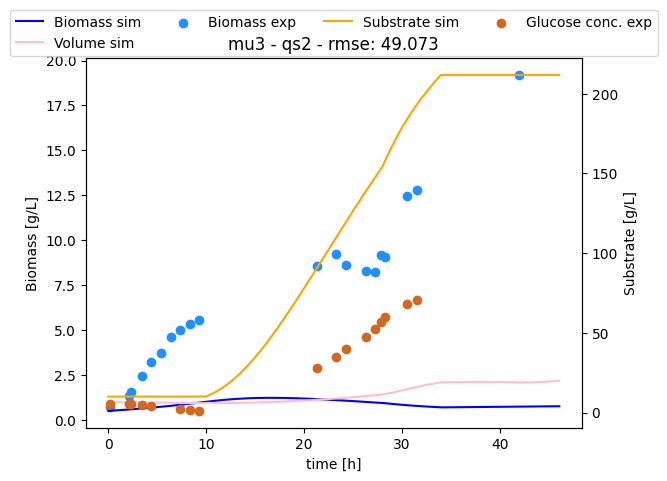

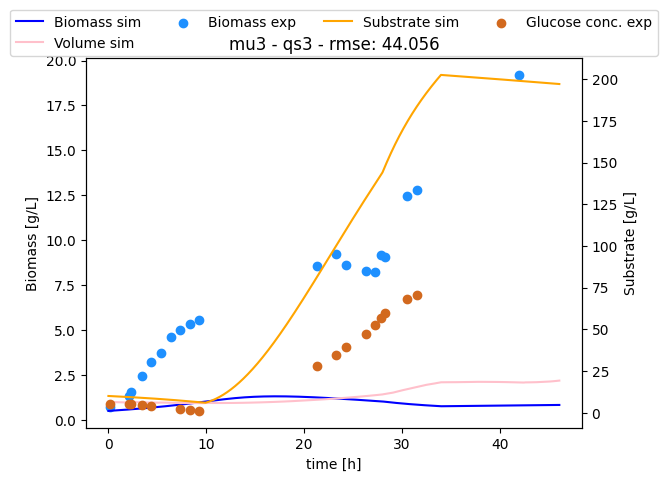

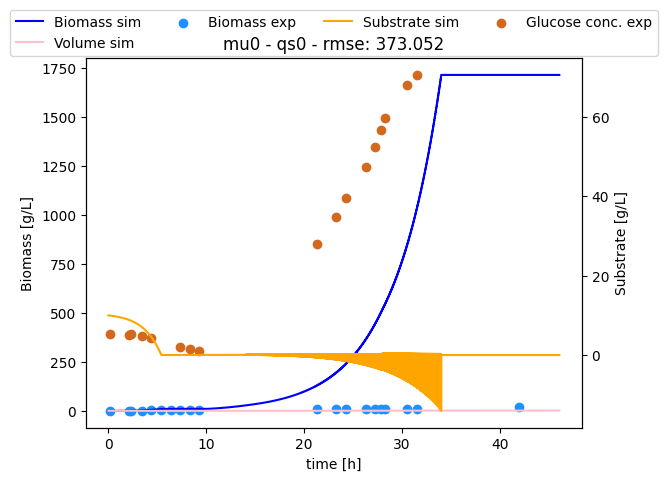

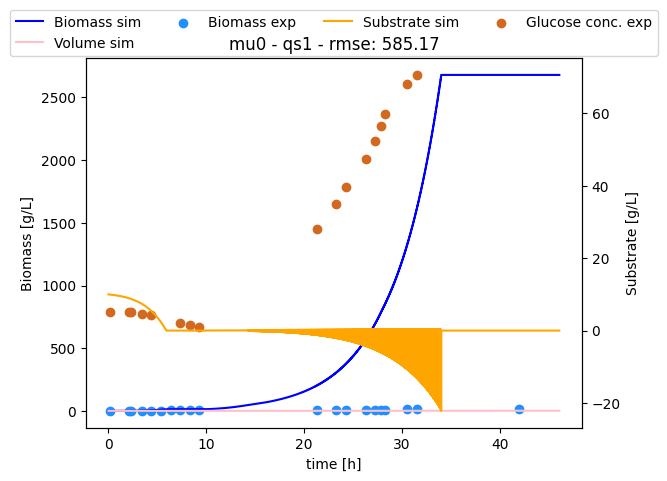

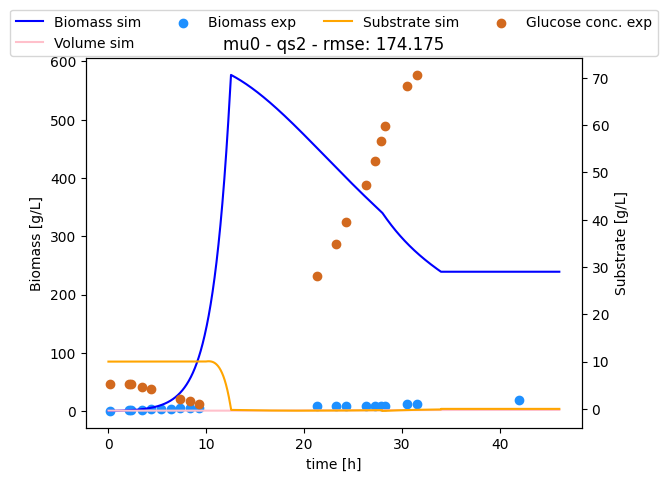

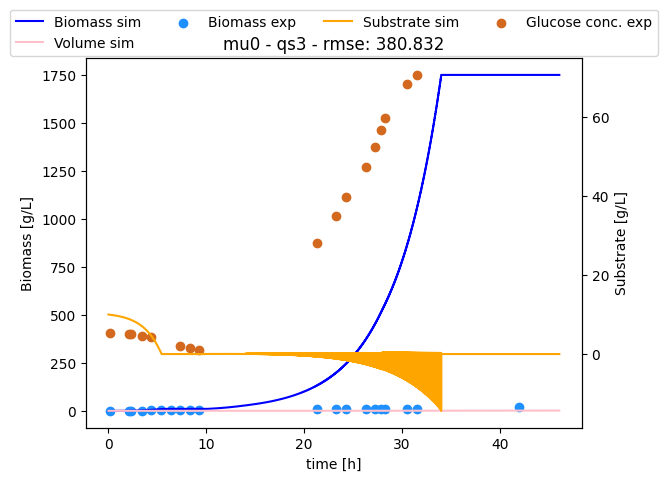

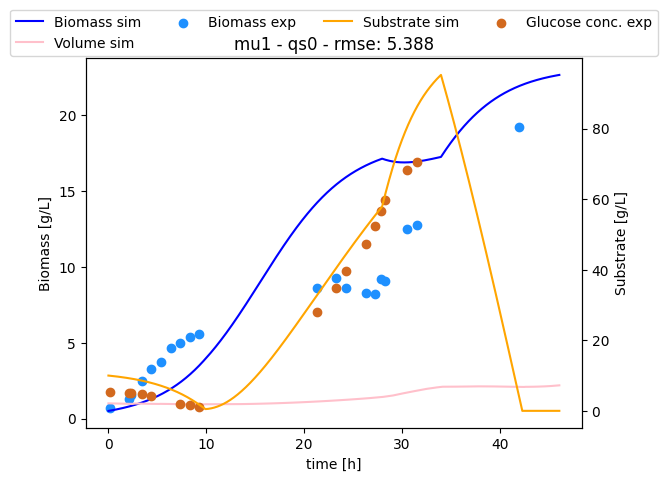

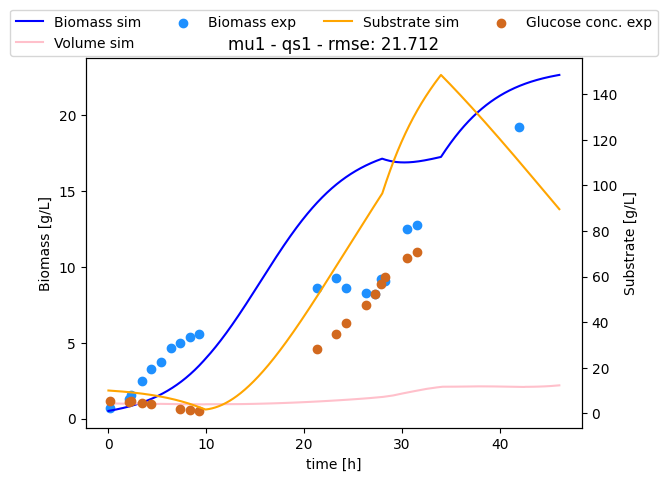

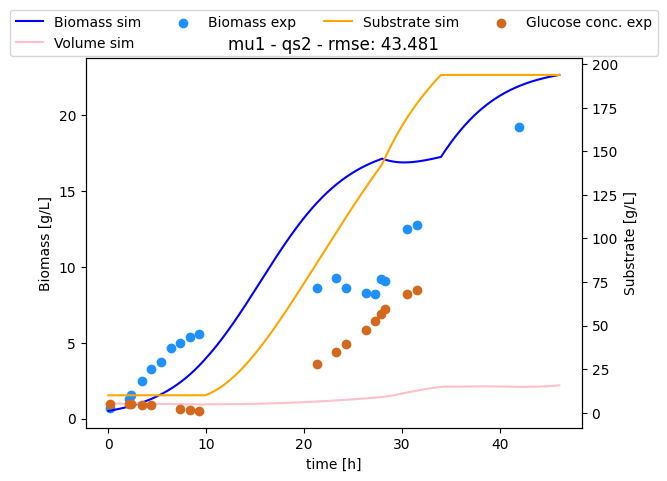

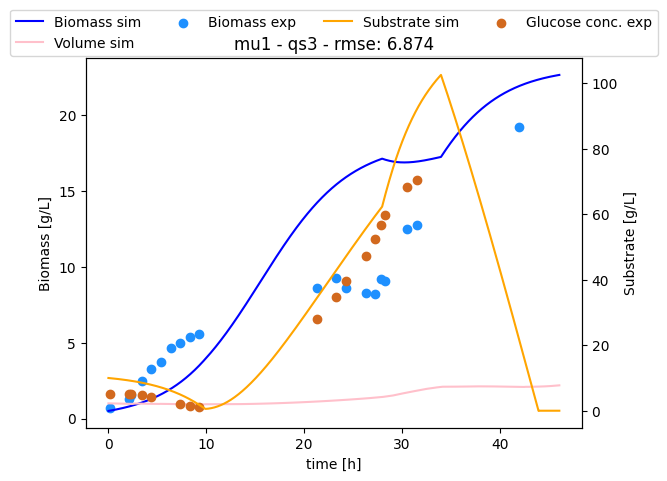

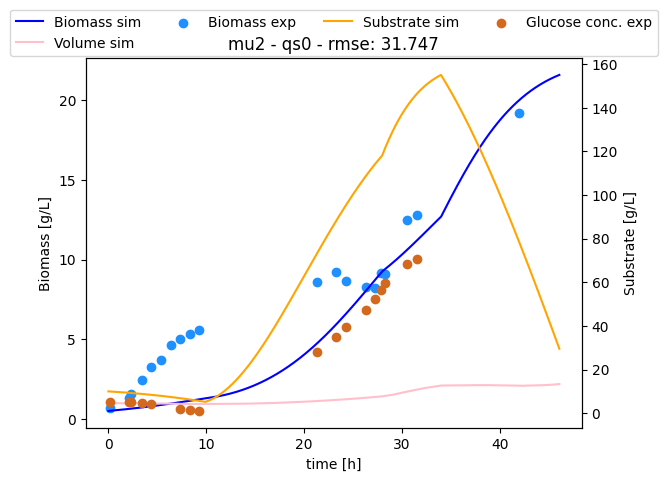

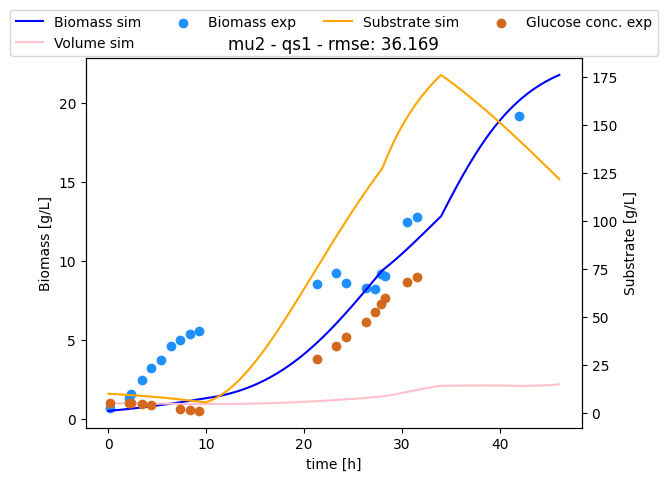

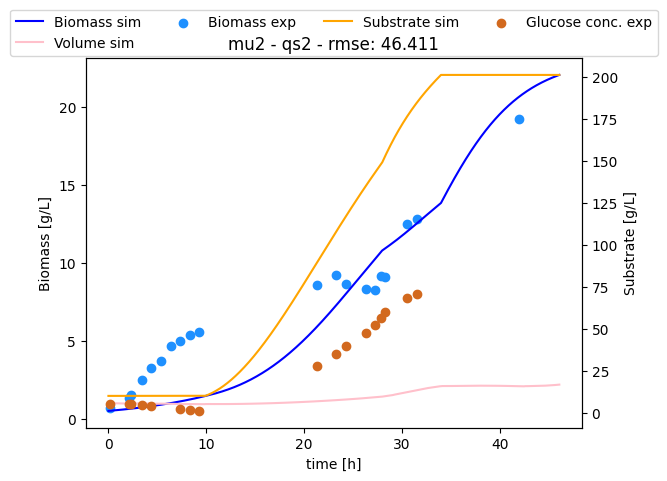

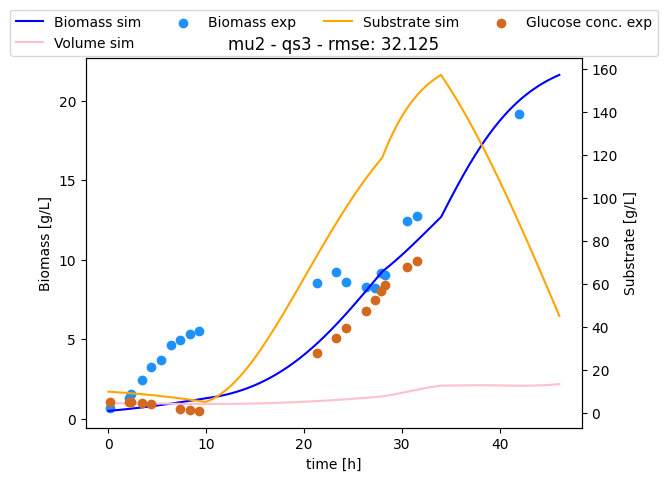

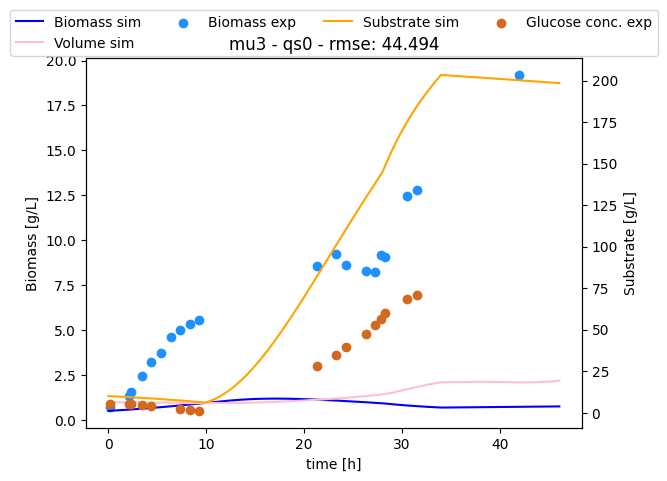

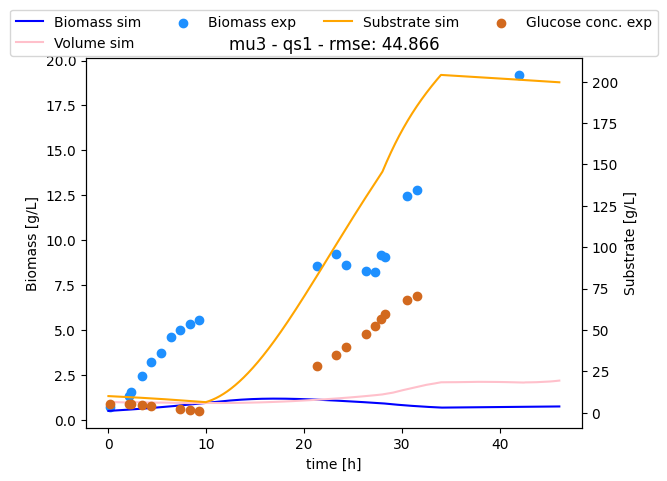

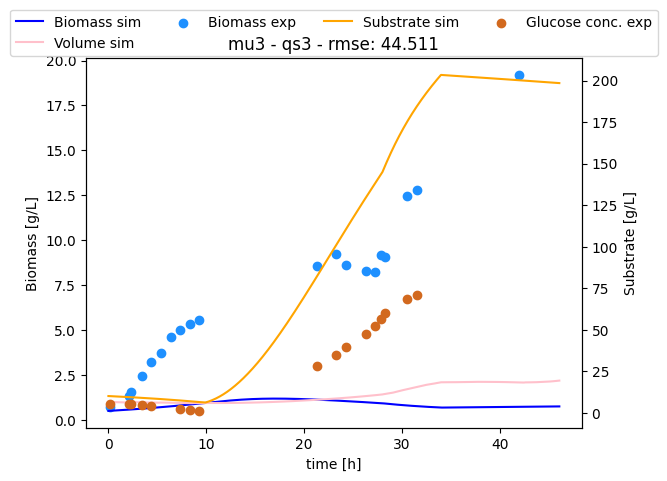

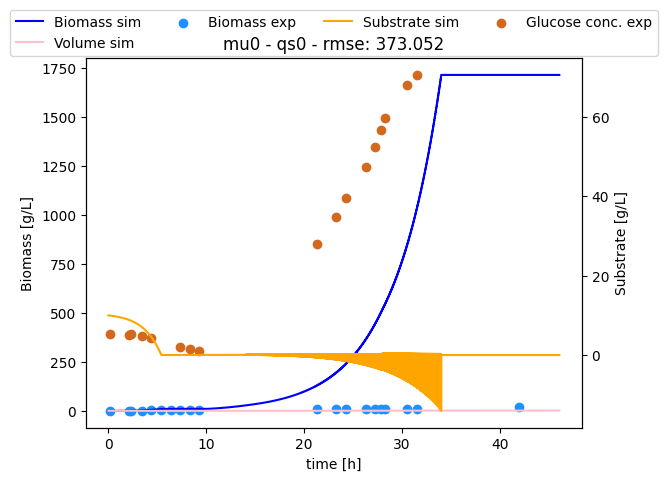

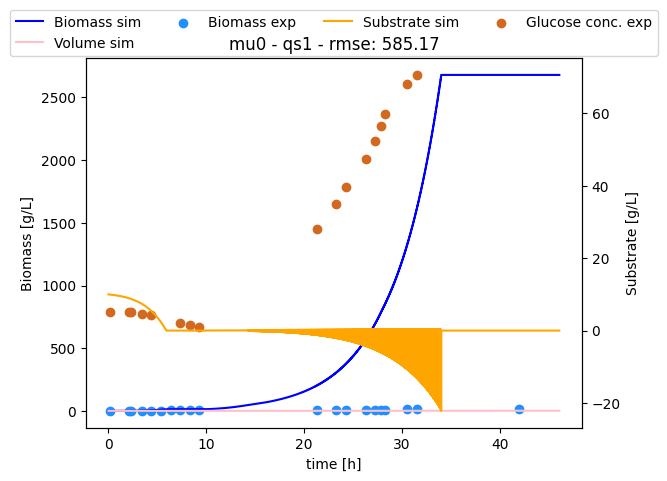

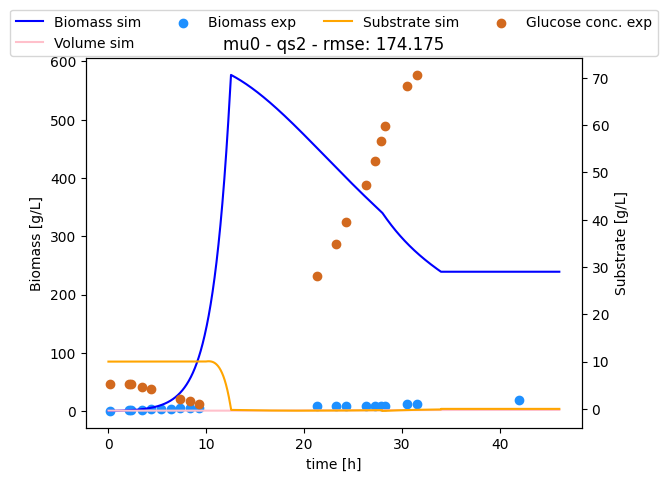

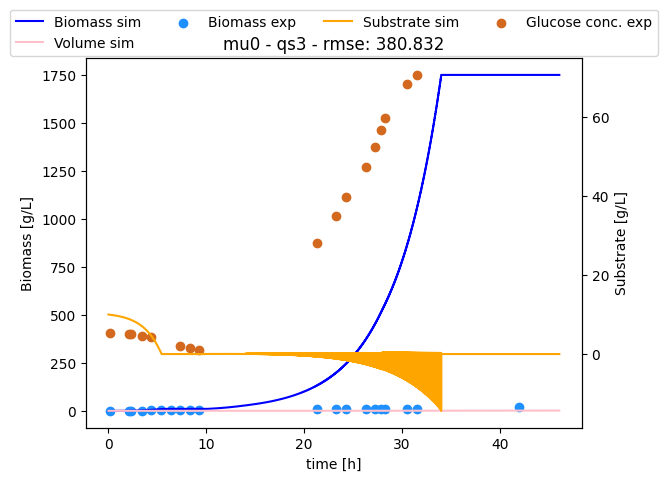

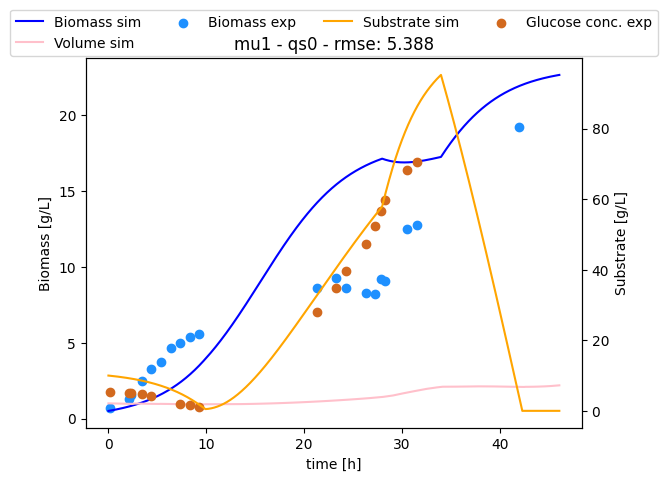

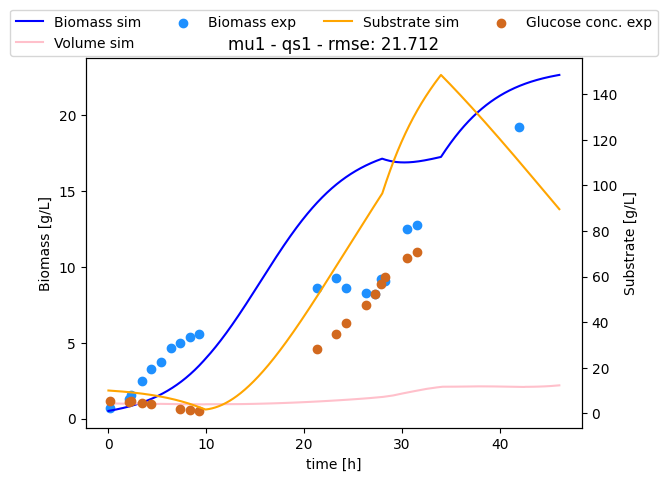

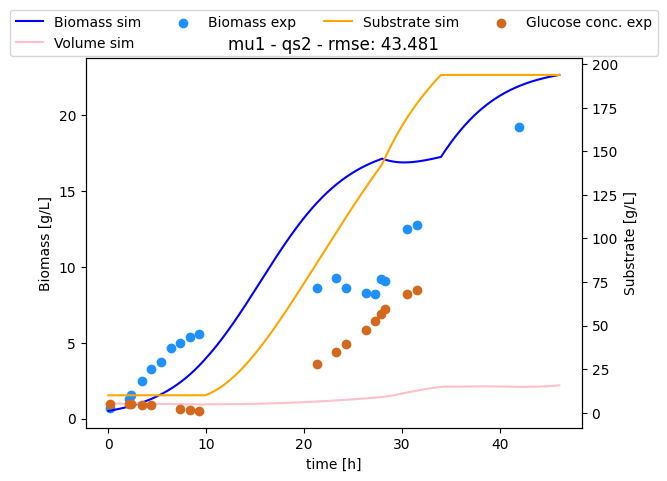

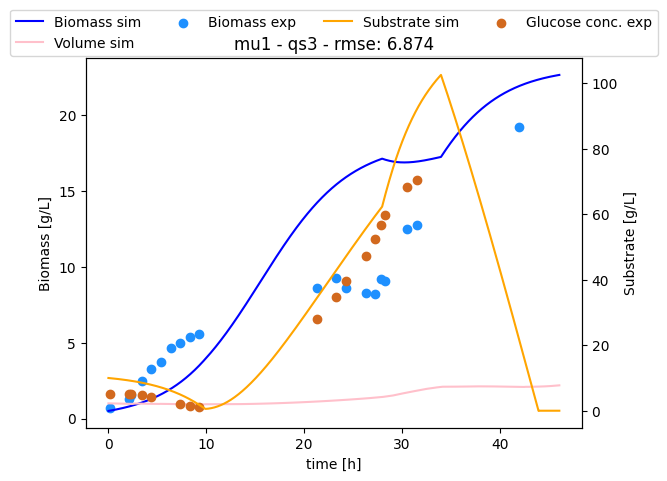

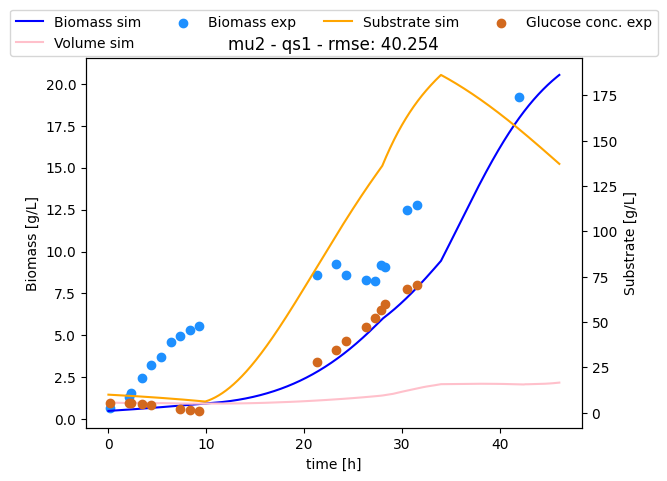

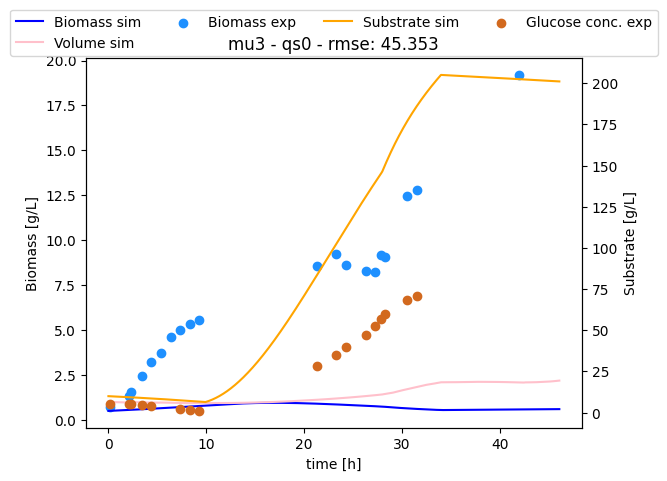

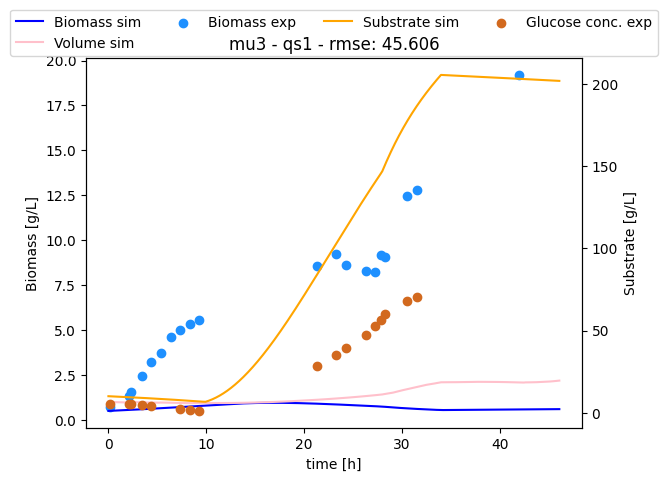

In [9]:
df_all_sets = pd.DataFrame(columns=['set', 'mu', 'qs', 'mu_max', 'X_max', 'Ks', 'Ks_qs', 'Ki', 'Yxs', 'qs_max', 'm_s', 'lag', 'rmse'])
for set_num in range(5):
    # Save all parameters and equations and the RMSE in a dataframe
    ## with the beginning of one set a new rmse_overview will be created
    rmse_one_set = []
    key = f'set{set_num}'
    init_p = est_Ks[key]
    for i in range(len(mu_all)):
        for j in range(len(qs_all)):
            # Define the combination of equations
            mu_eq = mu_all[i]; num_mu = i
            qs_eq = qs_all[j]; num_qs = j

            # Make the predictions and calculate the error
            rmse, time_pred, biomass_pred, substrate_pred, volume_pred = objective_function(init_p, mu_eq, num_mu, qs_eq, num_qs)
            # save the parameters in a dataframe
            append_list=[set_num, i, j, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], init_p[6], init_p[7], init_p[8], round(rmse, 3)]
            rmse_one_set.append(append_list)

            # Make a plot and save it
            title = f'set{set_num}/ mu{i} - qs{j} - rmse: {round(rmse, 3)}'
            plot_name = f'mu{i}_qs{j}'
            plot_estimation(time_pred, biomass_pred, substrate_pred, volume_pred, title, plot_name, set_num)

    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'mu', 'qs', 'mu_max', 'X_max', 'Ks', 'Ks_qs', 'Ki', 'Yxs', 'qs_max', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)


df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
df_all_sets.to_csv(f'data/estimation/Ks/data.csv')

df_all_sets.head(10)